# Transfer Learning Part 1: Feature extraction

## Import the data

In [ ]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [ ]:
# import zipfile
# zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
# zip_ref.extractall()
# zip_ref.close()

In [ ]:
# !mv 10_food_classes_10_percent '/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice'

In [ ]:
import os
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {str(dirpath).replace('/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/', '')}.")

There are 2 directories and 0 images in 10_food_classes_10_percent.
There are 10 directories and 0 images in 10_food_classes_10_percent/train.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice.
There are

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/10_food_classes_10_percent/train"
test_dir = "/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode="categorical")
test_data = test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE, class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Callbacks

Callbacks are special objects you can pass to model.fit() (or sometimes model.evaluate(), model.predict()).
They let you customize and control what happens during training, after each batch, after each epoch, or at the start/end of training.

They are super useful for:

* Saving the best model during training

* Stopping training early if it stops improving

* Adjusting the learning rate

* Logging metrics

* Writing TensorBoard logs

* Custom behavior (like printing or modifying something)

In [ ]:
# Create TensorBoard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

## Creating Models with Tensorflow Hub

We can access pretrained models on tfhub.dev

In [ ]:
efficientnet_url = 'https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2'
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's create the function
def create_model(model_url, num_classes=10):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [ ]:
# Create resnet model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Create efficientnet model
efficientnet_model = create_model(efficientnet_url, num_classes=train_data.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [ ]:
# Compile the resnet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
resnet_history_1 = resnet_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 callbacks = [create_tensorboard_callback(dir_name='tensorboard_hub',
                                                          experiment_name='resnet50V2')])

Saving TensorBoard log files to: tensorboard_hub/resnet50V2/20250722-123457
Epoch 1/5
24/24 [==============================] - 881s 38s/step - loss: 0.9041 - accuracy: 0.7080 - val_loss: 0.8283 - val_accuracy: 0.7380
Epoch 2/5
24/24 [==============================] - 600s 26s/step - loss: 0.6114 - accuracy: 0.8213 - val_loss: 0.7337 - val_accuracy: 0.7680
Epoch 3/5
24/24 [==============================] - 599s 26s/step - loss: 0.4635 - accuracy: 0.8813 - val_loss: 0.7020 - val_accuracy: 0.7796
Epoch 4/5
24/24 [==============================] - 593s 26s/step - loss: 0.3731 - accuracy: 0.9147 - val_loss: 0.6620 - val_accuracy: 0.7920
Epoch 5/5
24/24 [==============================] - 605s 26s/step - loss: 0.3114 - accuracy: 0.9387 - val_loss: 0.6582 - val_accuracy: 0.7880


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

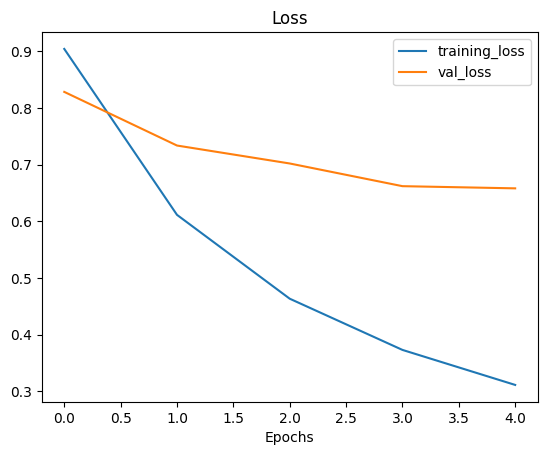

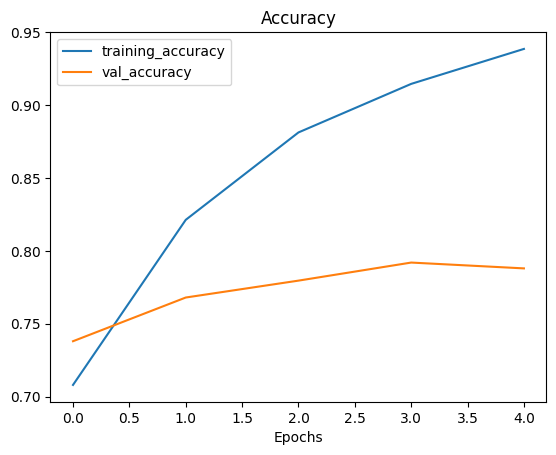

In [ ]:
plot_loss_curves(resnet_history_1)

In [ ]:
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       callbacks=[create_tensorboard_callback(dir_name='tensorboard_hub',
                                                              experiment_name='efficientnetB0')])

## Comparing our models' results using Tensorboard
Get familiar with tensorboard dev

In [ ]:
# Upload Tensorboard dev records
!tensorboard dev upload --logdir ./tensorboard_hub/ \
 --name 'Resnet50' \
 --description 'Just trying this tensorboard' \
 --one_shot

2025-07-22 13:33:06.680242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-22 13:33:06.680345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-22 13:33:06.695307: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-22 13:33:09.958878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb